In [1]:
# In the root of the repo run "pip install --editable ."

# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

# Data Exploration Script

Author: Clemens Jochum

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from src.data.import_data import import_df_from_zip_pkl
from src.data.make_dataset import remove_clipping_with_flexible_window, remove_clipping_with_universal_window

In [80]:
from warnings import filterwarnings
filterwarnings('ignore')

plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams['figure.dpi'] = 250
#'font.size': 10, 'savefig.dpi': 72, 'figure.subplot.bottom': 0.125

### Import Datasets

Use a random dataset for each type of synthetic data.

In [81]:
path_to_data_raw = '../data/raw/'

list_data_keys = ['basic', 'soil', 'soil_weather_locations']
list_index_random = np.random.randint(50, size=len(list_data_keys))

dict_index_dataset = {}
for (data_key, dataset_index) in zip(list_data_keys, list_index_random):
    dict_index_dataset[data_key] = dataset_index
    
dict_data_paths = {}
for data_key in list_data_keys:
    dict_data_paths[data_key] = '{0:s}/synthetic_{1:s}.zip'.format(path_to_data_raw, data_key)

In [82]:
dict_df = {}
for data_key in list_data_keys:
    dict_df[data_key] = {}
    dict_df[data_key]['T'] = import_df_from_zip_pkl(dict_data_paths[data_key], dict_index_dataset[data_key])

In [83]:
dict_df['soil']['T'].head()

,Power,POA,Tamb,Wind,Degradation,Soiling,Faults,minute_of_day
datetime,,,,,,,,
2015-01-01 00:00:00-05:00,-1.0,0.0,5.1,0.0,1.0,1.0,1,0
2015-01-01 00:01:00-05:00,-1.0,0.0,5.1,0.0,1.0,1.0,1,1
2015-01-01 00:02:00-05:00,-1.0,0.0,5.1,0.0,1.0,1.0,1,2
2015-01-01 00:03:00-05:00,-1.0,0.0,5.1,0.0,1.0,1.0,1,3
2015-01-01 00:04:00-05:00,-1.0,0.0,5.1,0.0,1.0,1.0,1,4


### Resample Datasets

Downsample minutes ('T') to hours ('H'), days ('D'), weeks ('W'), months ('MS'), and years ('AS') using mean.

In [84]:
list_resample_rules = ['H', 'D', 'W', 'MS', 'AS']

dict_label_resample_rules = {
    'T' : 'minute',
    'H' : 'hour',
    'D' : 'day',
    'W' : 'week',
    'MS' : 'month',
    'AS' : 'year',
}

dict_timeunits_per_year = {
    'MS' : 12,
    'W' : 52,
    'D' : 365,
    'H' : 24 * 365,
    'T' : 60 * 24 * 365,
}

In [85]:
for data_key in list_data_keys:
    for resample_rule in list_resample_rules:
        #dict_df[data_key]['T'] = remove_clipping_with_universal_window(dict_df[data_key]['T'])
        dict_df[data_key][resample_rule] = dict_df[data_key]['T'].resample(resample_rule).mean()

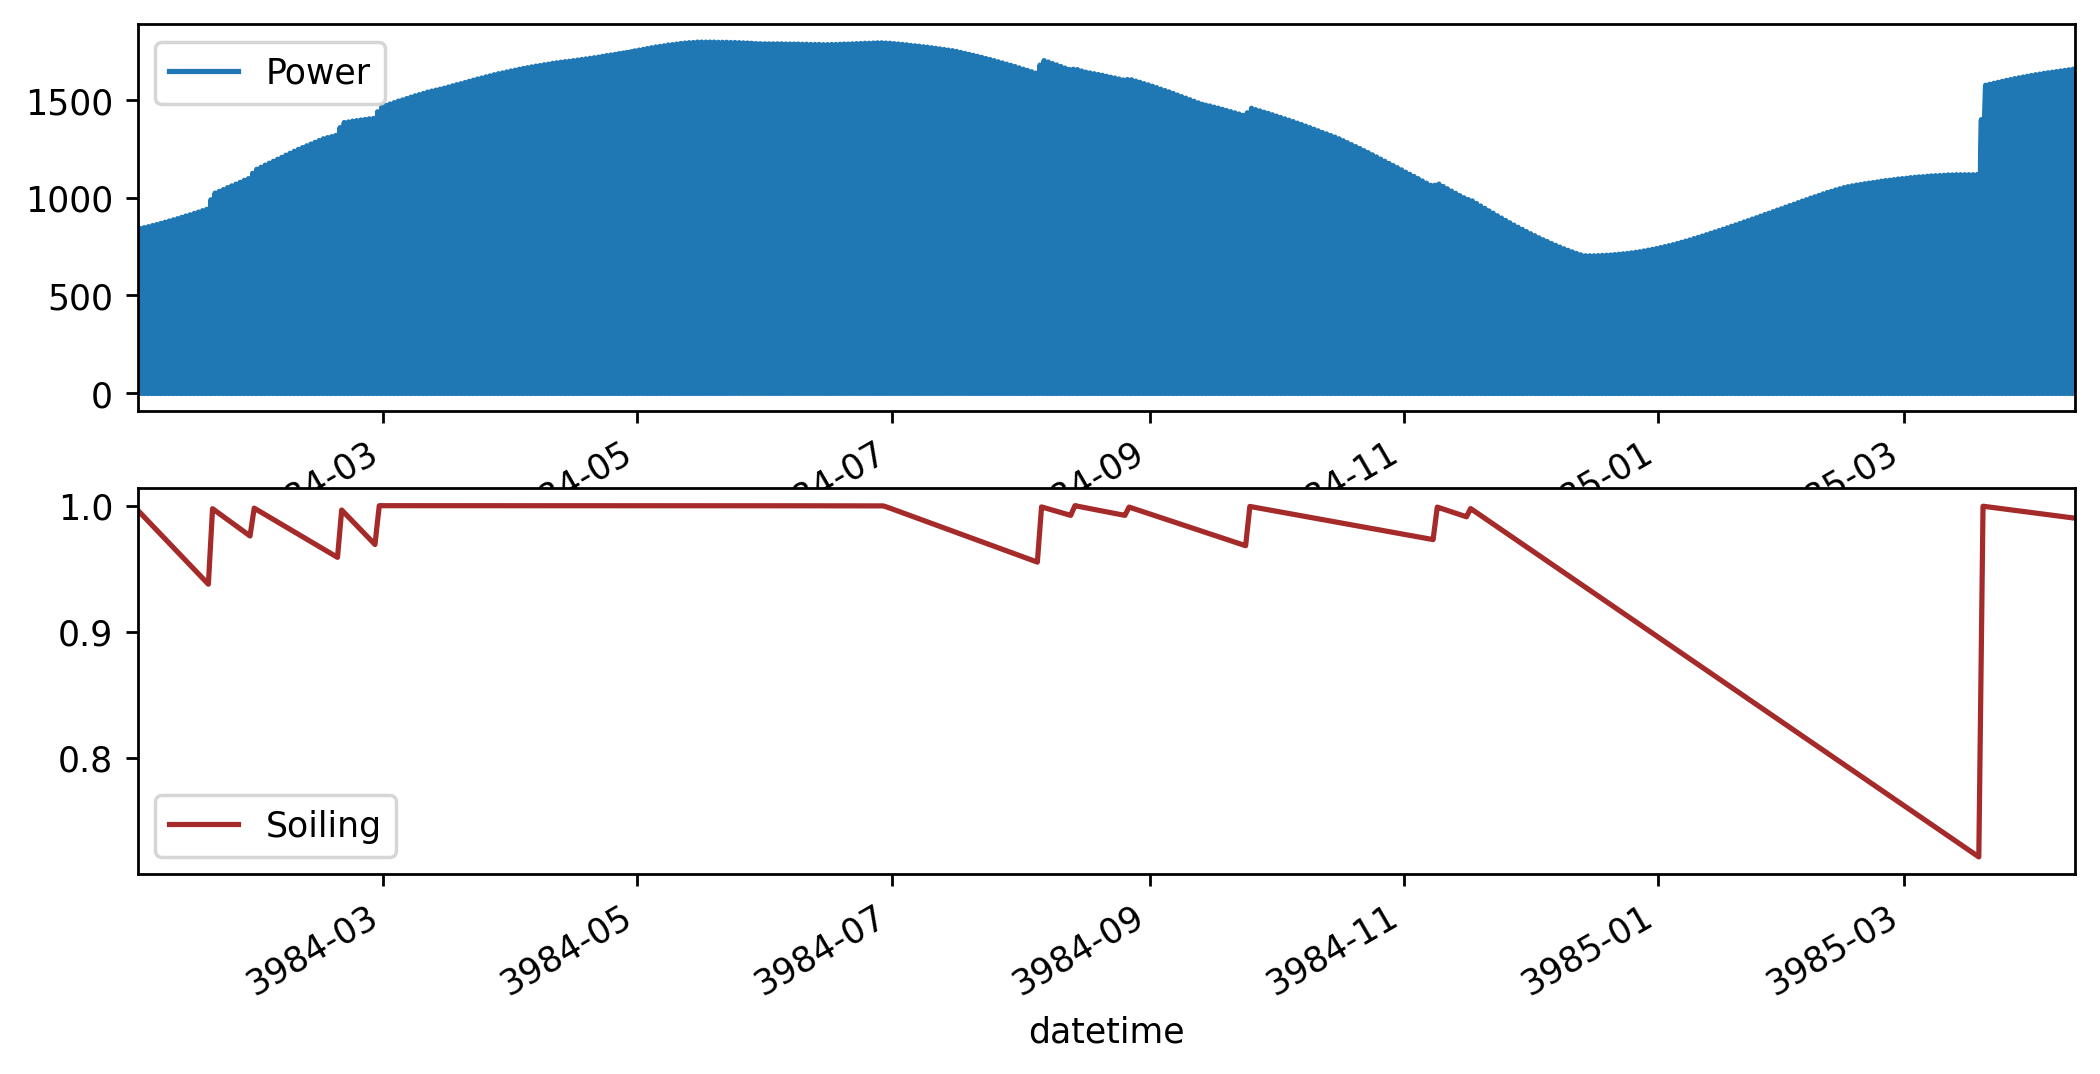

In [78]:
plt.rcParams["figure.figsize"] = [10, 5]
fig, axarr = plt.subplots(2,1)
dict_df['soil']['T'][['Power']][0:365*1440].plot(ax=axarr[0])
dict_df['soil']['T'][['Soiling']][0:365*1440].plot(ax=axarr[1], color='brown')
plt.show()


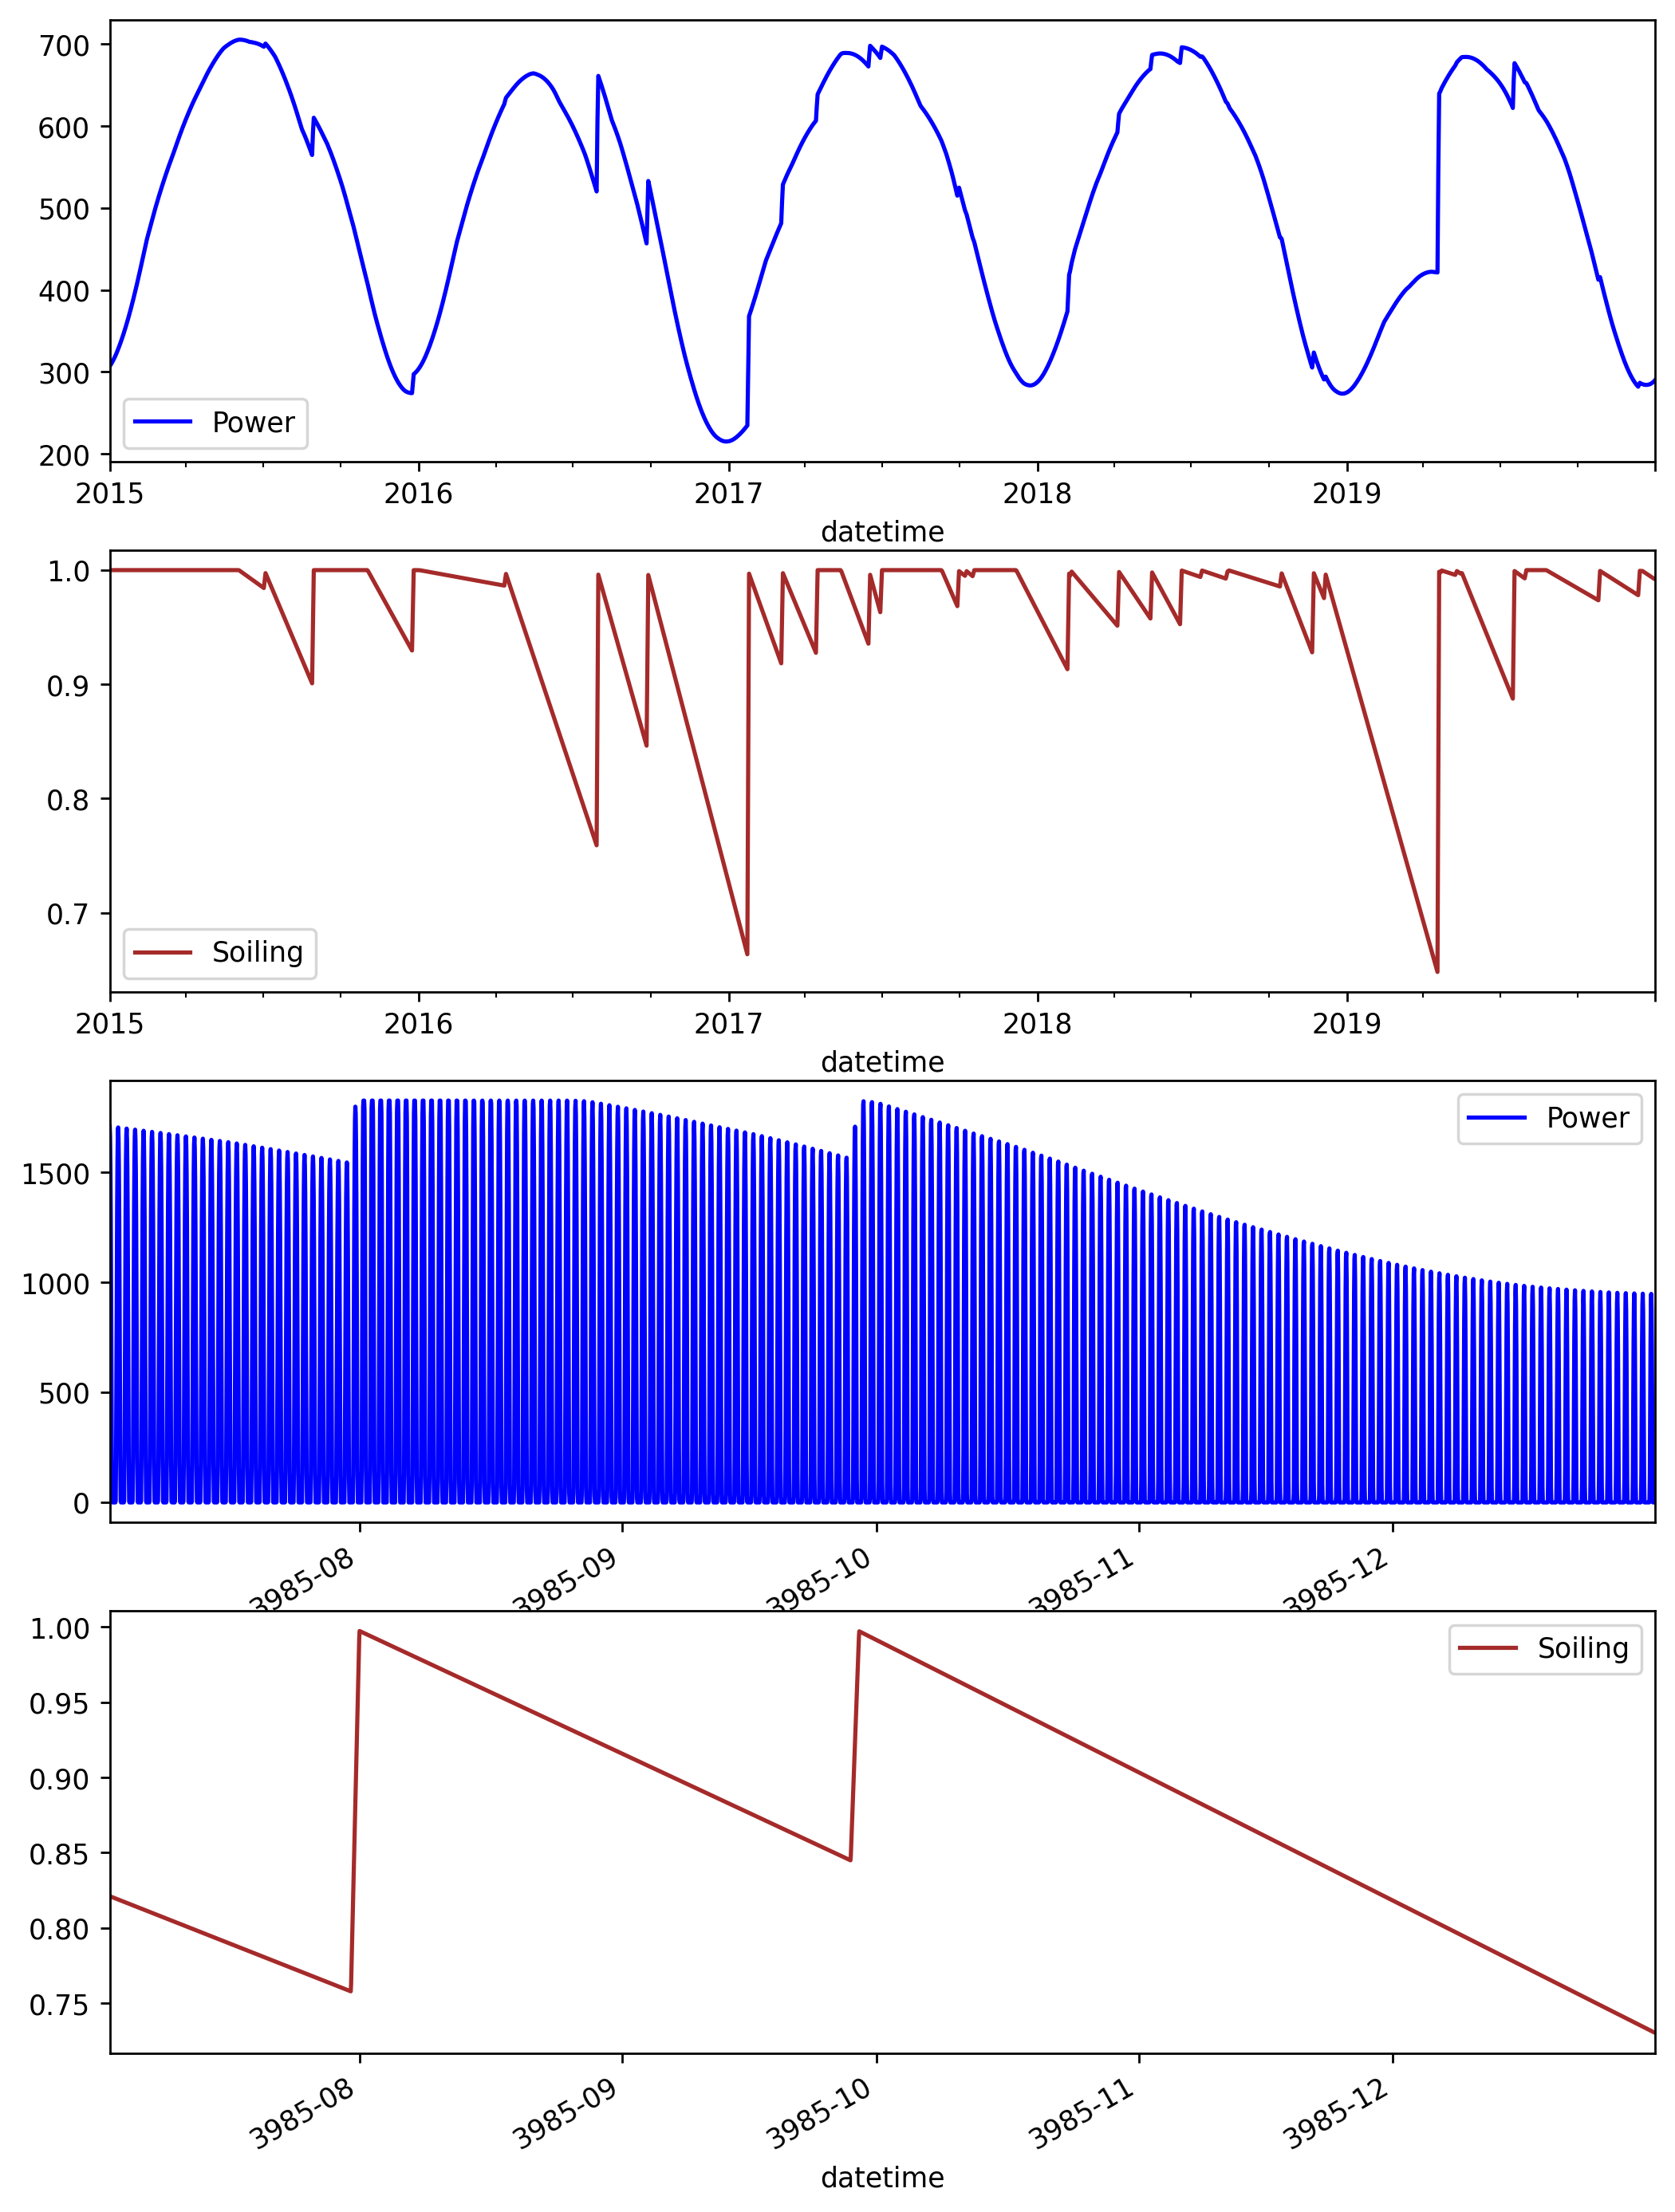

In [89]:
tmin = int(1.5 * dict_timeunits_per_year['H'])
tmax = int(2.0 * dict_timeunits_per_year['H'])

plt.rcParams["figure.figsize"] = [10, 15]
fig, axarr = plt.subplots(4,1)
dict_df['soil']['D'][['Power']].plot(ax=axarr[0], color = 'blue', label='Power')
dict_df['soil']['D'][['Soiling']].plot(ax=axarr[1], color='brown', label='Soiling')
dict_df['soil']['H'][['Power']][tmin:tmax].plot(ax=axarr[2], color = 'blue', label='Power')
dict_df['soil']['H'][['Soiling']][tmin:tmax].plot(ax=axarr[3], color='brown', label='Soiling')

#axarr[2].set_xlim(pd.Timestamp('3985-01-01'), pd.Timestamp('3986-01-01'))
#axarr[3].set_xlim(pd.Timestamp('3985-01-01'), pd.Timestamp('3986-01-01'))
plt.show()

In [151]:
def find_cleaning_events_running_window(data_frame_daily, left_window_size, right_window_size, window_overlap):
    
    left_window_average = data_frame_daily.rolling(left_window_size).max() 
    right_window_average = data_frame_daily.rolling(right_window_size).max()
    
    window_offset = left_window_size - window_overlap
    difference_window_average = right_window_average.to_numpy()[window_offset:] - left_window_average.to_numpy()[:-window_offset]
    difference_window_average /= right_window_average.to_numpy()[window_offset:]
    
    return difference_window_average
    

In [118]:
find_cleaning_events_running_window(dict_df['soil']['D']['Power'], 3, 3, 1)

2
datetime
2015-01-03 00:00:00-05:00    308.457176
2015-01-04 00:00:00-05:00    310.151852
2015-01-05 00:00:00-05:00    311.969213
2015-01-06 00:00:00-05:00    313.903009
2015-01-07 00:00:00-05:00    315.955556
                                ...    
2019-12-27 00:00:00-05:00    285.626157
2019-12-28 00:00:00-05:00    286.261806
2019-12-29 00:00:00-05:00    287.015046
2019-12-30 00:00:00-05:00    287.877778
2019-12-31 00:00:00-05:00    288.886574
Freq: D, Name: Power, Length: 1824, dtype: float64
datetime
2015-01-01 00:00:00-05:00           NaN
2015-01-02 00:00:00-05:00           NaN
2015-01-03 00:00:00-05:00    308.457176
2015-01-04 00:00:00-05:00    310.151852
2015-01-05 00:00:00-05:00    311.969213
                                ...    
2019-12-25 00:00:00-05:00    284.707176
2019-12-26 00:00:00-05:00    285.107639
2019-12-27 00:00:00-05:00    285.626157
2019-12-28 00:00:00-05:00    286.261806
2019-12-29 00:00:00-05:00    287.015046
Freq: D, Name: Power, Length: 1824, dtype: float6

array([       nan,        nan, 3.51203704, ..., 1.38888889, 1.61597222,
       1.87152778])

In [120]:
diff_avg = find_cleaning_events_running_window(dict_df['soil']['D']['Power'], 3, 3, 1)

2
datetime
2015-01-03 00:00:00-05:00    308.457176
2015-01-04 00:00:00-05:00    310.151852
2015-01-05 00:00:00-05:00    311.969213
2015-01-06 00:00:00-05:00    313.903009
2015-01-07 00:00:00-05:00    315.955556
                                ...    
2019-12-27 00:00:00-05:00    285.626157
2019-12-28 00:00:00-05:00    286.261806
2019-12-29 00:00:00-05:00    287.015046
2019-12-30 00:00:00-05:00    287.877778
2019-12-31 00:00:00-05:00    288.886574
Freq: D, Name: Power, Length: 1824, dtype: float64
datetime
2015-01-01 00:00:00-05:00           NaN
2015-01-02 00:00:00-05:00           NaN
2015-01-03 00:00:00-05:00    308.457176
2015-01-04 00:00:00-05:00    310.151852
2015-01-05 00:00:00-05:00    311.969213
                                ...    
2019-12-25 00:00:00-05:00    284.707176
2019-12-26 00:00:00-05:00    285.107639
2019-12-27 00:00:00-05:00    285.626157
2019-12-28 00:00:00-05:00    286.261806
2019-12-29 00:00:00-05:00    287.015046
Freq: D, Name: Power, Length: 1824, dtype: float6

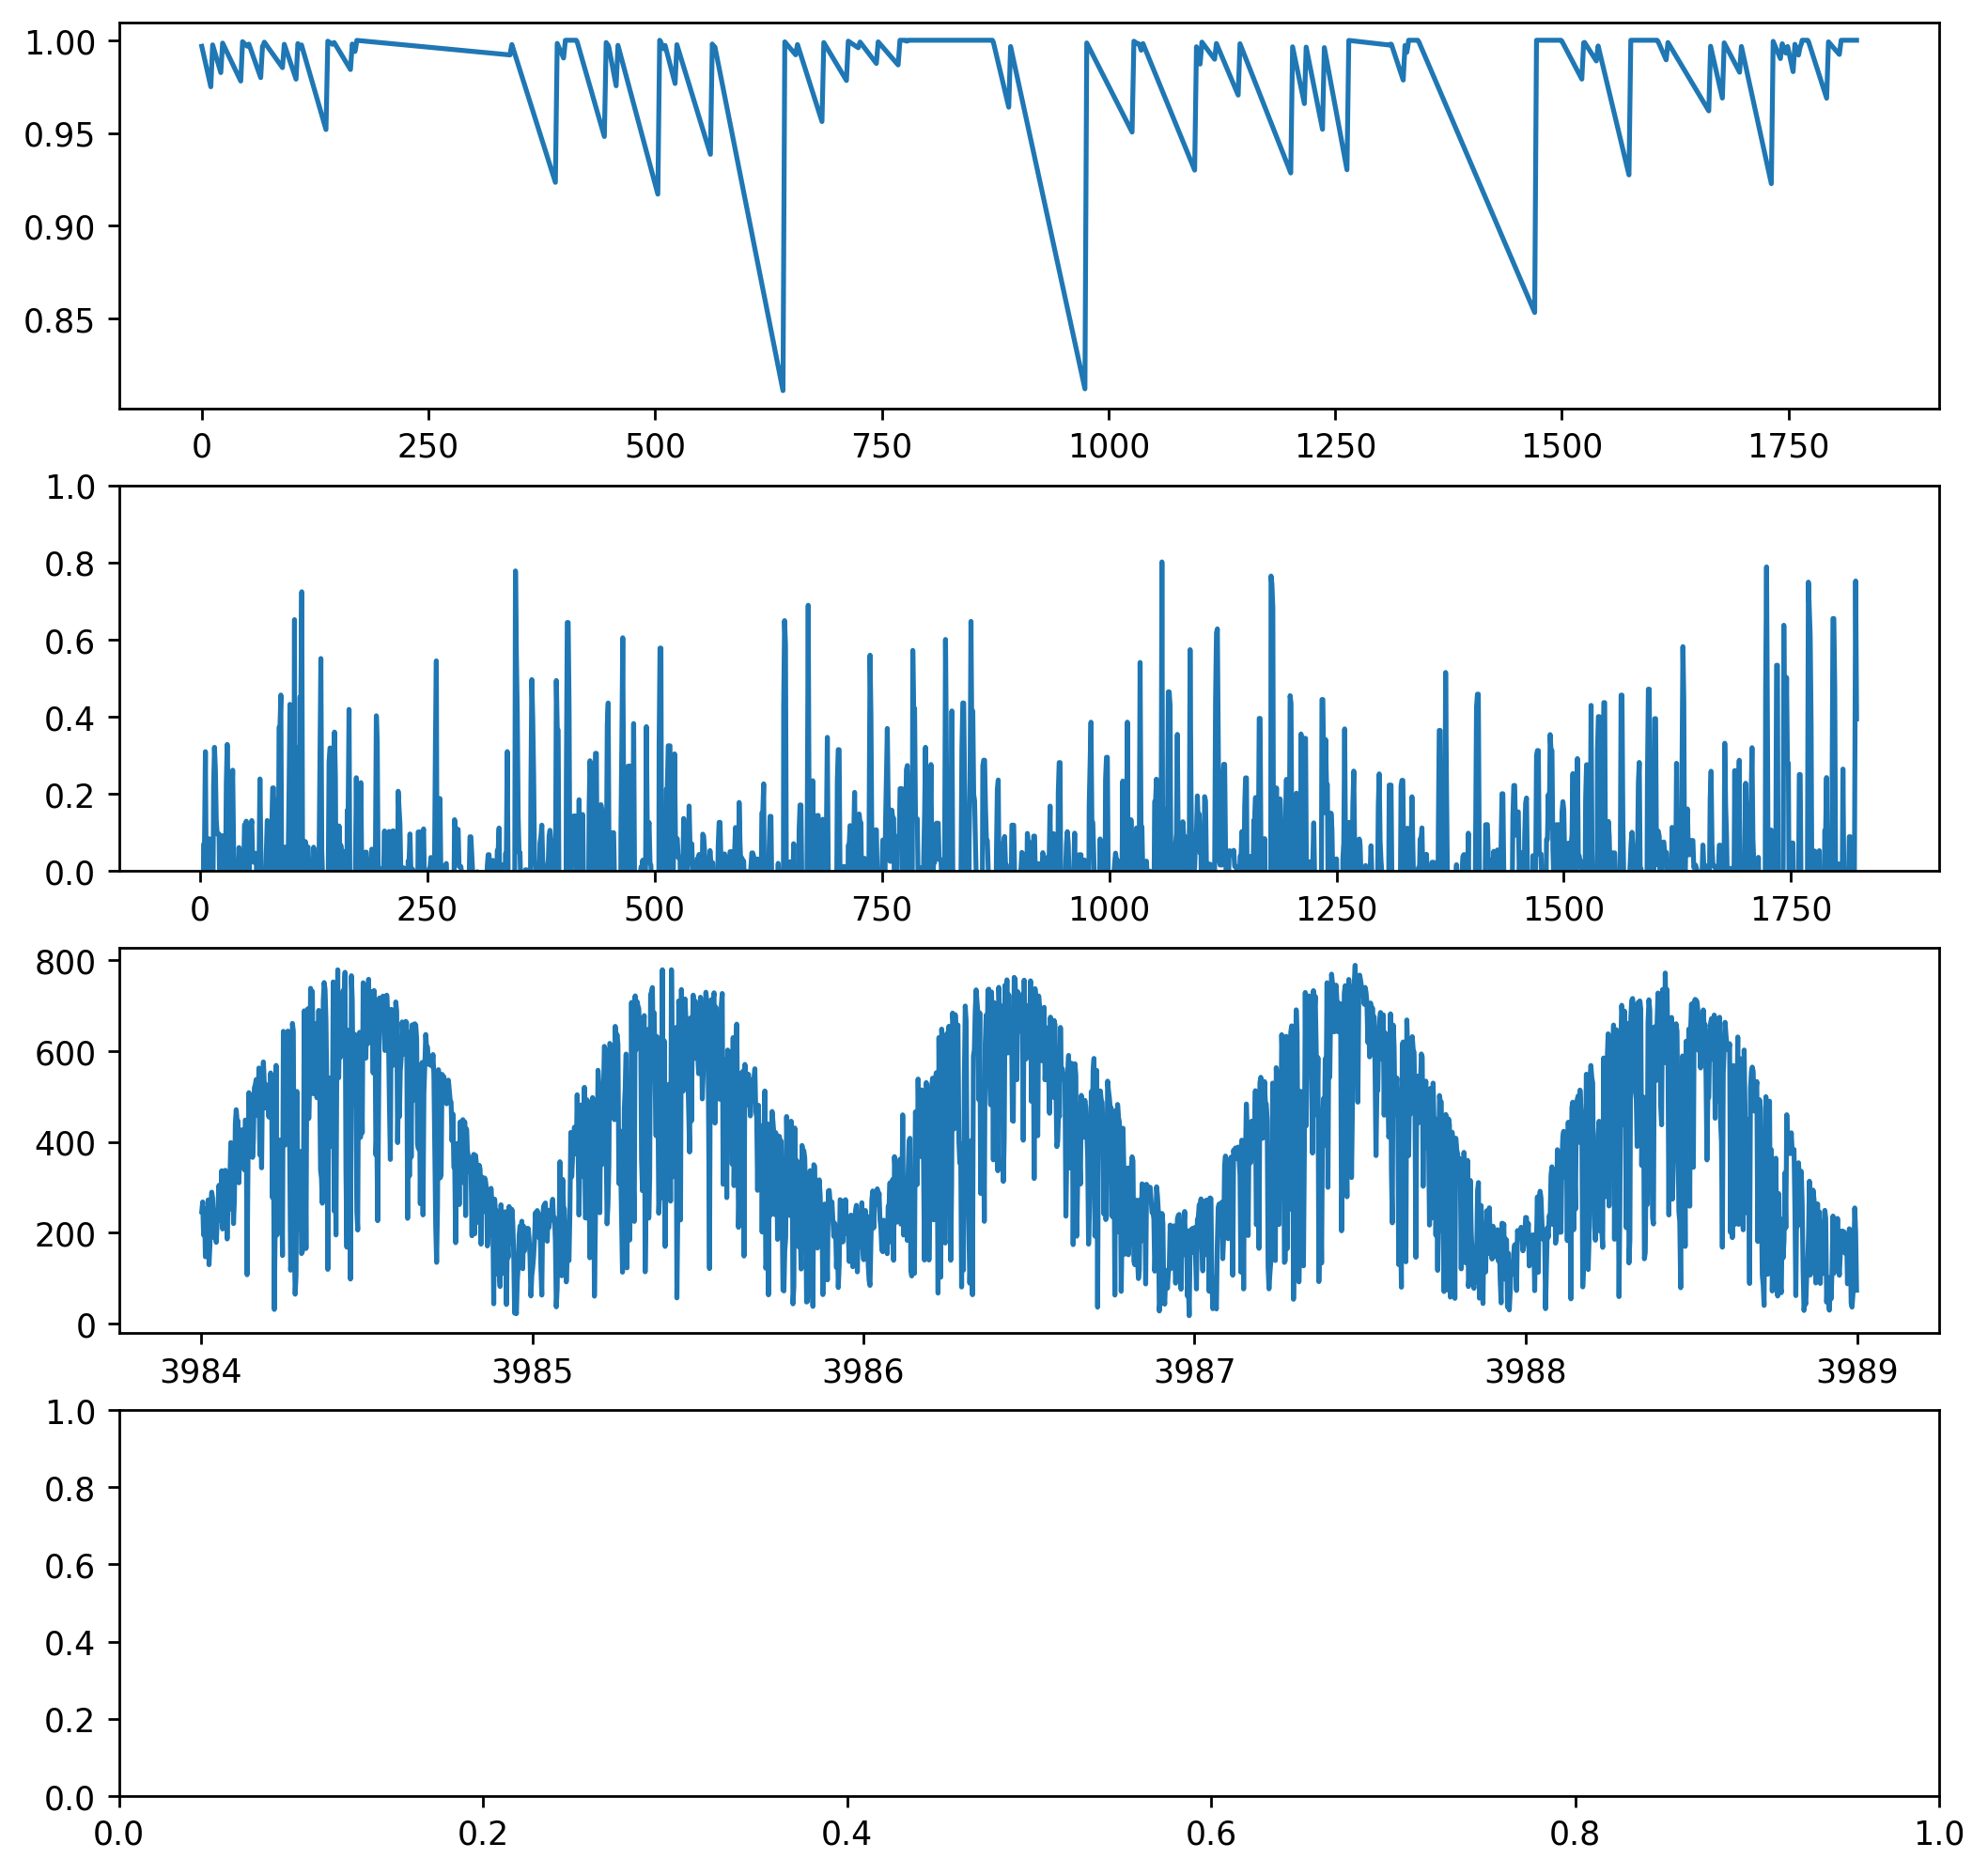

In [153]:
df = dict_df['soil_weather_locations']['D']

window_size = 3
window_overlap_1 = 0
window_overlap_2 = 1


diff_avg_1 = find_cleaning_events_running_window(df['Power'], window_size, window_size, window_overlap_1)
diff_avg_2 = find_cleaning_events_running_window(df['Power'], window_size, window_size, window_overlap_2)

plt.rcParams["figure.figsize"] = [10, 10]
fig, axarr = plt.subplots(4)

axarr[0].plot(df['Soiling'].to_numpy())
axarr[1].plot(diff_avg_1)
#axarr[2].plot(diff_avg_2)
axarr[2].plot(df['Power'])

axarr[1].set_ylim([0., 1.])

plt.show()